In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import sklearn as sk

In [11]:
def df_transformation(df):
    df_temp = df[features]
    df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

    output = df_temp.groupby(by=["datetime"], dropna=False).mean().reset_index()
    
    return output 

In [12]:
# Create a custom function for data transformation
# May as well import all of these features into the initial dataframe, you can cut it down..
# ..when you do the X,y train/test split
features = ['datetime',
            'latitude',
            'longitude',
            'absoluteAltitude',
            'magneticHeading',
            'trueHeading',
            'groundSpeed',
            'trueAirspeed',
            'pitch',
            'roll',
            'yaw',
            'angleOfAttack',
            'flightPathAngle',
            'verticalFlightPathAngle',
            'horizontalFlightPathAngle',
            'rollAcceleration',
            'pitchAcceleration',
            'yawAcceleration',
            'e1N1ng',
            'e2N1ng',
            'e1N2nf',
            'e2N2nf',
            'mainRotorRpm',
            'tailRotorRpm',
            'mainRotorTorque',
            'e1Itt',
            'e2Itt',
            'mainRotorInducedInflow',
            'flightDirectorPitch',
            'flightDirectorRoll',
            'climbOrDescentRate',
            'hasWeightOnWheels',
            'turnRate to degPerSec',
            'cyclicPositionPitch',
            'cyclicPositionRoll',
            'collectivePosition',
            'antiTorquePedalPosition',
            'throttlePosition',
            'e1Torque',
            'e2Torque'
           ]


In [13]:
# reading files from 9/19 dataset
df1 = pd.read_csv('SimData_2022.09.19_16.00.36.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
df1 = df_transformation(df1)


df2 = pd.read_csv('SimData_2022.09.19_16.38.20.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
df2 = df_transformation(df2)


df3 = pd.read_csv('SimData_2022.09.19_17.51.37.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
df3 = df_transformation(df3)



# reading files from 9/20 dataset
first_file = pd.read_csv('SimData_2022.09.20_16.22.07.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
first_file = df_transformation(first_file)


second_file = pd.read_csv('SimData_2022.09.20_16.28.31.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
second_file = df_transformation(second_file)


# reading file from 9/22 dataset
#df4 = pd.read_csv('SimData_2022.09.22_17.11.56.csv.roar.csv',
#                parse_dates = {'datetime': ['date', 'time']},
#                low_memory=False)
#df4 = df_transformation(df4)

C:\Users\kanev\AppData\Local\Temp\ipykernel_716\17026926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')
C:\Users\kanev\AppData\Local\Temp\ipykernel_716\17026926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')
C:\Users\kanev\AppData\Local\Temp\ipykernel_716\17026926.py:3: SettingWithCopyWarning: 
A value is t

In [14]:
#Combine files
df = pd.concat([first_file,second_file, df1, df2, df3]).reset_index()
len(df)

5133

# Hover Taxi - DataFrame Labelling

In [15]:
df_h = df.copy()
df_h['hover'] = 0

df_h.loc[(df_h['datetime'].between('2022-09-19 21:57:07' , '2022-09-19 21:59:20' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-19 22:08:15' , '2022-09-19 22:10:24' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:28:44' , '2022-09-20 20:30:06' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:30:31' , '2022-09-20 20:32:16' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:32:39' , '2022-09-20 20:34:06' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-20 20:34:50' , '2022-09-20 20:36:51' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:20:41' , '2022-09-22 21:23:56' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:28:35' , '2022-09-22 21:29:46' , inclusive='both')),['hover']] = 1
df_h.loc[(df_h['datetime'].between('2022-09-22 21:44:09' , '2022-09-22 21:45:31' , inclusive='both')),['hover']] = 1


# Hover Taxi - Model Features and Class Balance

In [16]:
#Edit the model features to whatever you want to include in your model
all_features = ['hasWeightOnWheels',
                  'absoluteAltitude',
                  'magneticHeading',
                  'groundSpeed',
                  'climbOrDescentRate',
                  'turnRate to degPerSec',
                  'cyclicPositionPitch',
                  'cyclicPositionRoll',
                  'collectivePosition',
                  'antiTorquePedalPosition',
                  'throttlePosition',
                  'e1Torque',
                  'e2Torque',
                  'hover'
               ]

df_h = df_h[all_features]

In [17]:
#orginal class imbalance
df_h['hover'].value_counts()

0    4470
1     663
Name: hover, dtype: int64

In [18]:
#call features used in model
model_features = ['hasWeightOnWheels',
                  'absoluteAltitude',
                  'magneticHeading',
                  'groundSpeed',
                  'climbOrDescentRate',
                  'turnRate to degPerSec',
                  'cyclicPositionPitch',
                  'cyclicPositionRoll',
                  'collectivePosition',
                  'antiTorquePedalPosition',
                  'throttlePosition',
                  'e1Torque',
                  'e2Torque'
                 ]

In [19]:
#call OverSampler using 'minority' to 
ros = RandomOverSampler(sampling_strategy='minority')

In [20]:
#set x and y to respective features
hover_x, hover_y = df_h[model_features], df_h['hover']

In [21]:
#resample
hover_x, hover_y = ros.fit_resample(hover_x, hover_y)

In [22]:
#new class balance
hover_y.value_counts()

0    4470
1    4470
Name: hover, dtype: int64

# Hover Taxi - XGBoost Model

In [27]:
#train and test split for model
hover_x_train, hover_x_test, hover_y_train, hover_y_test = sk.model_selection.train_test_split(hover_x,hover_y,test_size=0.2,random_state=777)

In [28]:
#call XG Boost model and fit to data
hover_model = XGBClassifier(use_label_encoder=False)
hover_model.fit(hover_x_train, hover_y_train)

[12:57:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [29]:
#training model prediction
hover_train_pred = hover_model.predict(hover_x_train)

In [30]:
#test model prediction
hover_pred = hover_model.predict(hover_x_test)

In [31]:
#accuracy scores
hover_train_acc = sk.metrics.accuracy_score(hover_y_train, hover_train_pred)
hover_test_acc = sk.metrics.accuracy_score(hover_y_test, hover_pred)

In [32]:
print("Train Accuracy: %.2f%%" % (hover_train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (hover_test_acc * 100.0))

Train Accuracy: 100.00%
Test Accuracy: 99.61%


In [33]:
#auc roc scores
hover_train_roc = sk.metrics.roc_auc_score(hover_y_train, hover_train_pred)
hover_test_roc = sk.metrics.roc_auc_score(hover_y_test, hover_pred)

In [34]:
print("Train ROC AUC Score: %.2f%%" % (hover_train_roc * 100.0))
print("Test ROC AUC Score: %.2f%%" % (hover_test_roc * 100.0))

Train ROC AUC Score: 100.00%
Test ROC AUC Score: 99.59%


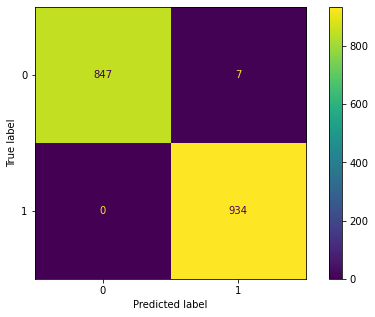

In [35]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(hover_y_test, hover_pred),)
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


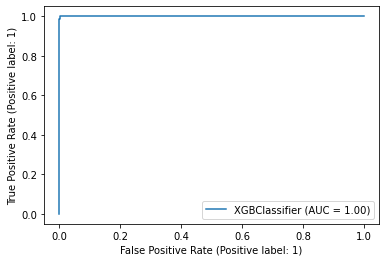

In [36]:
#auc roc plot
sk.metrics.plot_roc_curve(hover_model, hover_x_test, hover_y_test)
plt.show()

# Surface Taxi - DataFrame Labelling

In [37]:
df_s = df.copy()
df_s['surface'] = 0

df_s.loc[(df_s['datetime'].between('2022-09-19 21:53:50' , '2022-09-19 21:55:55' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-19 22:04:00' , '2022-09-19 22:06:39' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-20 20:25:50' , '2022-09-20 20:27:54' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-22 21:16:37' , '2022-09-22 21:19:56' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-22 21:43:16' , '2022-09-22 21:43:41' , inclusive='both')),['surface']] = 1

In [41]:
#orginal class imbalance
df_s['surface'].value_counts()

0    4722
1     411
Name: surface, dtype: int64

# Surface Taxi - Model Features and Class Balance

In [45]:
#set x and y to respective features
surface_x, surface_y = df_s[model_features], df_s['surface']

In [46]:
#resample
surface_x, surface_y = ros.fit_resample(surface_x, surface_y)

In [47]:
#new class balance
surface_y.value_counts()

0    4722
1    4722
Name: surface, dtype: int64

# Surface Taxi - XGBoost Model

In [50]:
#train and test split for model
surface_x_train, surface_x_test, surface_y_train, surface_y_test = sk.model_selection.train_test_split(surface_x,surface_y,test_size=0.2,random_state=777)

In [51]:
#call XG Boost model and fit to data
surface_model = XGBClassifier(use_label_encoder=False)
surface_model.fit(surface_x_train, surface_y_train)

[13:02:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [52]:
#training model prediction
surface_train_pred = surface_model.predict(surface_x_train)

In [53]:
#test model prediction
surface_pred = surface_model.predict(surface_x_test)

In [54]:
#accuracy scores
surface_train_acc = sk.metrics.accuracy_score(surface_y_train, surface_train_pred)
surface_test_acc = sk.metrics.accuracy_score(surface_y_test, surface_pred)

In [55]:
print("Train Accuracy: %.2f%%" % (surface_train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (surface_test_acc * 100.0))

Train Accuracy: 100.00%
Test Accuracy: 99.79%


In [56]:
#auc roc scores
surface_train_roc = sk.metrics.roc_auc_score(surface_y_train, surface_train_pred)
surface_test_roc = sk.metrics.roc_auc_score(surface_y_test, surface_pred)

In [57]:
print("Train ROC AUC Score: %.2f%%" % (surface_train_roc * 100.0))
print("Test ROC AUC Score: %.2f%%" % (surface_test_roc * 100.0))

Train ROC AUC Score: 100.00%
Test ROC AUC Score: 99.79%


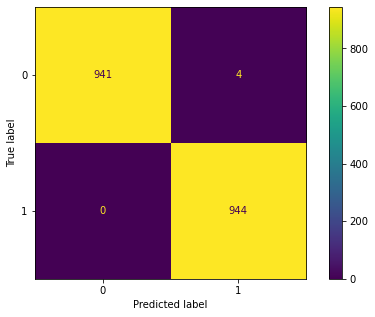

In [58]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(surface_y_test, surface_pred),)
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


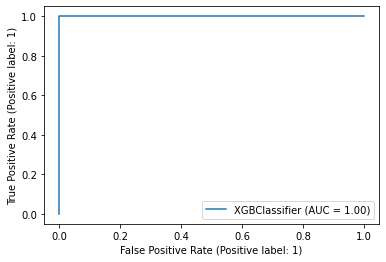

In [59]:
#auc roc plot
sk.metrics.plot_roc_curve(surface_model, surface_x_test, surface_y_test)
plt.show()